In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [2]:
db_user = 'postgres'
db_password = '123456'
db_host = 'localhost'
db_port = '5432'
db_name = 'nordic_co2'

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Denmark

## General Analysis

In [3]:
query_dk_general = '''
WITH dk_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), dk_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), dk_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), dk_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), total_summary AS (
    SELECT * FROM dk_2021_summary
    UNION ALL
    SELECT * FROM dk_2022_summary
    UNION ALL
    SELECT * FROM dk_2023_summary
    UNION ALL
    SELECT * FROM dk_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    month_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, month_grouped;
'''

dk_general = pd.read_sql_query(query_dk_general, engine)

In [4]:
dk_general.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Denmark,DK,1.0,158574.07,140536.32,-11.37,215154.47,190412.53,-11.50,64.98,69.88
1,2021,Denmark,DK,2.0,140536.32,114471.01,-18.55,190412.53,164417.37,-13.65,65.89,70.02
2,2021,Denmark,DK,3.0,114471.01,87814.07,-23.29,164417.37,136052.60,-17.25,72.72,77.84
3,2021,Denmark,DK,4.0,87814.07,77478.25,-11.77,136052.60,125661.22,-7.64,76.53,82.41
4,2021,Denmark,DK,5.0,77478.25,89436.53,15.43,125661.22,132249.17,5.24,77.06,84.52


In [5]:
dk_general.rename(columns={'year_':'year'}, inplace=True)
dk_general.rename(columns={'month_grouped':'month'}, inplace=True)

In [6]:
dk_general.dtypes

year                             object
country                          object
zone_id                          object
month                           float64
total_direct_carbon_emission    float64
next_direct_carbon_emission     float64
direct_decrease_or_increase     float64
total_lca_carbon_emission       float64
next_lca_carbon_emission        float64
lca_decrease_or_increase        float64
avg_renewable_percentage        float64
avg_low_carbon_percentage       float64
dtype: object

In [7]:
dk_general.year = dk_general.year.astype(int)
dk_general.month = dk_general.month.astype(int)

### Statistics

In [8]:
dk_general.describe()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,48.000000,48.000000,48.000000,47.000000,47.000000,48.00000,47.000000,47.000000,48.000000,48.000000
mean,2022.500000,6.500000,77288.009583,75558.518936,2.218723,116871.50625,114780.379362,0.933404,76.992500,84.050833
std,1.129865,3.488583,31752.364778,29722.626553,33.866039,37983.76014,35491.866951,26.289207,4.486074,5.484828
min,2021.000000,1.000000,31842.110000,31842.110000,-39.230000,61812.86000,61812.860000,-33.760000,64.980000,69.880000
25%,2021.750000,3.750000,50007.835000,49366.540000,-22.765000,85270.95000,84044.880000,-17.045000,74.452500,81.102500
50%,2022.500000,6.500000,77426.890000,77375.530000,-11.440000,120109.66500,119795.510000,-9.380000,77.065000,84.350000
75%,2023.250000,9.250000,99124.767500,98716.805000,22.925000,141154.87500,138198.285000,18.600000,79.735000,88.580000
max,2024.000000,12.000000,158574.070000,140536.320000,124.380000,215154.47000,190412.530000,98.290000,84.780000,92.280000


<Axes: >

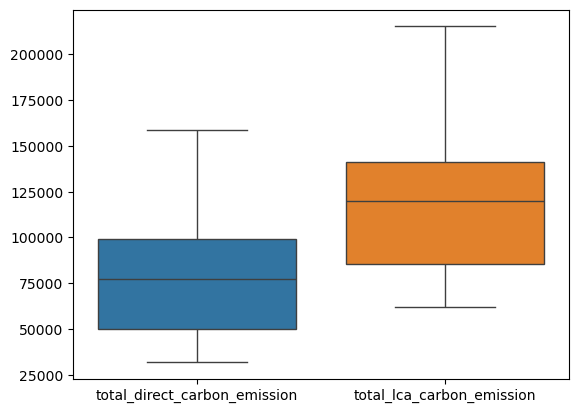

In [9]:
sns.boxplot(dk_general[['total_direct_carbon_emission', 'total_lca_carbon_emission']])

<Axes: >

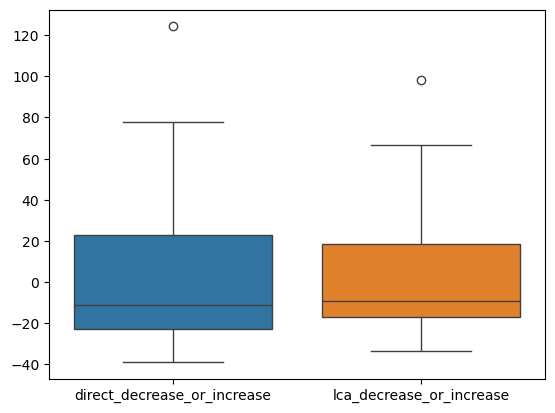

In [10]:
sns.boxplot(dk_general[['direct_decrease_or_increase', 'lca_decrease_or_increase']])

In [11]:
dk_general[dk_general['direct_decrease_or_increase'] > 100]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
33,2023,Denmark,DK,10,37574.31,84310.08,124.38,61812.86,122570.52,98.29,83.4,91.18


In [12]:
dk_general.loc[[33, 34]]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
33,2023,Denmark,DK,10,37574.31,84310.08,124.38,61812.86,122570.52,98.29,83.40,91.18
34,2023,Denmark,DK,11,84310.08,99659.48,18.21,122570.52,143587.59,17.15,73.97,80.67


In [13]:
dk_general.select_dtypes(include='number').corr()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,4.864312e-14,-0.687943,-0.717163,0.003335,-0.679942,-0.708685,0.003223,0.578104,0.555989
month,4.864312e-14,1.000000e+00,-0.148893,0.092594,0.301524,-0.165031,0.075602,0.307536,0.161253,0.214264
total_direct_carbon_emission,-6.879429e-01,-1.488934e-01,1.000000,0.711213,-0.387034,0.993927,0.718458,-0.365079,-0.925733,-0.968527
next_direct_carbon_emission,-7.171628e-01,9.259424e-02,0.711213,1.000000,0.317112,0.698645,0.992917,0.339322,-0.599521,-0.647747
direct_decrease_or_increase,3.334578e-03,3.015244e-01,-0.387034,0.317112,1.000000,-0.403564,0.296774,0.983378,0.445120,0.435658
total_lca_carbon_emission,-6.799415e-01,-1.650307e-01,0.993927,0.698645,-0.403564,1.000000,0.712195,-0.388810,-0.916880,-0.972109
next_lca_carbon_emission,-7.086851e-01,7.560204e-02,0.718458,0.992917,0.296774,0.712195,1.000000,0.329684,-0.605734,-0.666691
lca_decrease_or_increase,3.222868e-03,3.075360e-01,-0.365079,0.339322,0.983378,-0.388810,0.329684,1.000000,0.415244,0.408821
avg_renewable_percentage,5.781040e-01,1.612530e-01,-0.925733,-0.599521,0.445120,-0.916880,-0.605734,0.415244,1.000000,0.921628
avg_low_carbon_percentage,5.559895e-01,2.142640e-01,-0.968527,-0.647747,0.435658,-0.972109,-0.666691,0.408821,0.921628,1.000000


In [14]:
#sns.pairplot(dk_general)

## Hourly Analysis

In [15]:
query_dk_hourly = '''
WITH dk_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), dk_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), dk_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), dk_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM denmark.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), total_summary AS (
    SELECT * FROM dk_2021_summary
    UNION ALL
    SELECT * FROM dk_2022_summary
    UNION ALL
    SELECT * FROM dk_2023_summary
    UNION ALL
    SELECT * FROM dk_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    hour_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, hour_grouped
'''

dk_hourly = pd.read_sql_query(query_dk_hourly, engine)

In [16]:
dk_hourly.head()

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Denmark,DK,0.0,47878.73,48071.69,0.40,69894.78,70231.37,0.48,73.90,82.16
1,2021,Denmark,DK,1.0,48071.69,48788.07,1.49,70231.37,71076.02,1.20,73.71,82.04
2,2021,Denmark,DK,2.0,48788.07,49709.44,1.89,71076.02,72060.32,1.38,73.48,81.79
3,2021,Denmark,DK,3.0,49709.44,53265.05,7.15,72060.32,76131.15,5.65,73.41,81.39
4,2021,Denmark,DK,4.0,53265.05,56412.27,5.91,76131.15,79774.19,4.79,72.93,79.94


In [17]:
dk_hourly.rename(columns={'year_':'year'}, inplace=True)
dk_hourly.rename(columns={'hour_grouped':'hour'}, inplace=True)

In [18]:
dk_hourly.year = dk_hourly.year.astype(int)
dk_hourly.hour = dk_hourly.hour.astype(int)

In [45]:
dk_hourly.to_excel('dk_hourly.xlsx')

In [19]:
dk_hourly.describe()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,95.000000,95.000000,96.000000,96.000000
mean,2022.500000,11.500000,38644.004792,38546.797158,-0.557053,58435.753125,58315.131789,-0.471158,76.993854,84.066979
std,1.123903,6.958524,11518.723110,11540.177486,5.340443,13578.099561,13598.327233,4.227428,3.248793,3.287935
min,2021.000000,0.000000,23954.830000,23954.830000,-38.680000,40454.340000,40454.340000,-30.560000,72.470000,77.820000
25%,2021.750000,5.750000,27667.392500,27655.395000,-2.695000,45680.895000,45614.830000,-2.175000,74.027500,81.435000
50%,2022.500000,11.500000,38077.565000,32404.190000,-0.170000,57441.895000,51343.150000,-0.200000,77.455000,84.120000
75%,2023.250000,17.250000,48502.732500,48597.845000,1.990000,70262.210000,70264.210000,1.425000,78.555000,87.052500
max,2024.000000,23.000000,57900.660000,57900.660000,7.520000,81481.430000,81481.430000,5.650000,84.370000,88.760000


<Axes: >

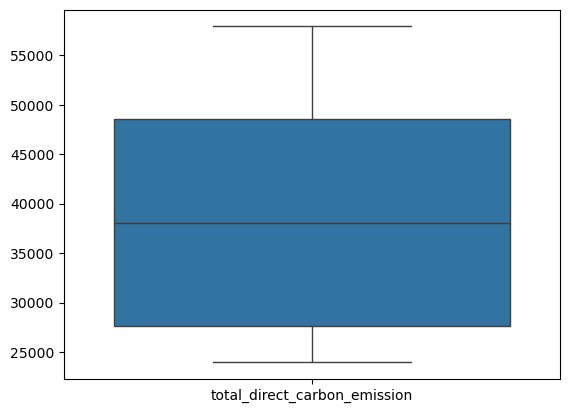

In [20]:
sns.boxplot(dk_hourly[['total_direct_carbon_emission']])

<Axes: >

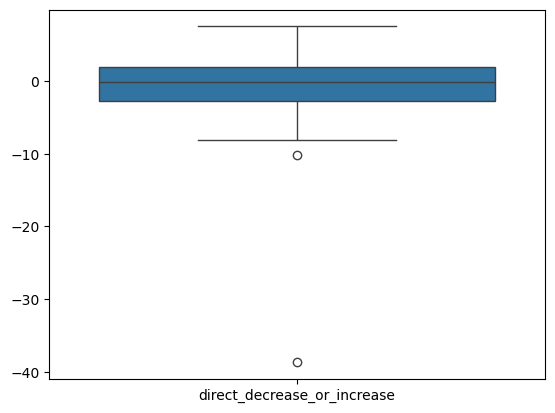

In [21]:
sns.boxplot(dk_hourly[['direct_decrease_or_increase']])

In [22]:
dk_hourly.select_dtypes(include='number').corr()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,2.451147e-14,-0.943184,-0.927397,0.044793,-0.946025,-0.928374,0.053345,0.791161,0.918445
hour,2.451147e-14,1.000000e+00,0.020686,-0.029235,-0.401113,0.025013,-0.030473,-0.435031,0.015615,-0.058180
total_direct_carbon_emission,-9.431836e-01,2.068594e-02,1.000000,0.981653,-0.058924,0.999135,0.980158,-0.061985,-0.844075,-0.981932
next_direct_carbon_emission,-9.273971e-01,-2.923452e-02,0.981653,1.000000,0.128501,0.981647,0.999139,0.125915,-0.820551,-0.965191
direct_decrease_or_increase,4.479287e-02,-4.011133e-01,-0.058924,0.128501,1.000000,-0.054881,0.132084,0.996242,0.103941,0.052703
total_lca_carbon_emission,-9.460251e-01,2.501350e-02,0.999135,0.981647,-0.054881,1.000000,0.981743,-0.058446,-0.832820,-0.984402
next_lca_carbon_emission,-9.283741e-01,-3.047332e-02,0.980158,0.999139,0.132084,0.981743,1.000000,0.130159,-0.809678,-0.967287
lca_decrease_or_increase,5.334547e-02,-4.350311e-01,-0.061985,0.125915,0.996242,-0.058446,0.130159,1.000000,0.100642,0.053074
avg_renewable_percentage,7.911613e-01,1.561477e-02,-0.844075,-0.820551,0.103941,-0.832820,-0.809678,0.100642,1.000000,0.848420
avg_low_carbon_percentage,9.184448e-01,-5.817978e-02,-0.981932,-0.965191,0.052703,-0.984402,-0.967287,0.053074,0.848420,1.000000


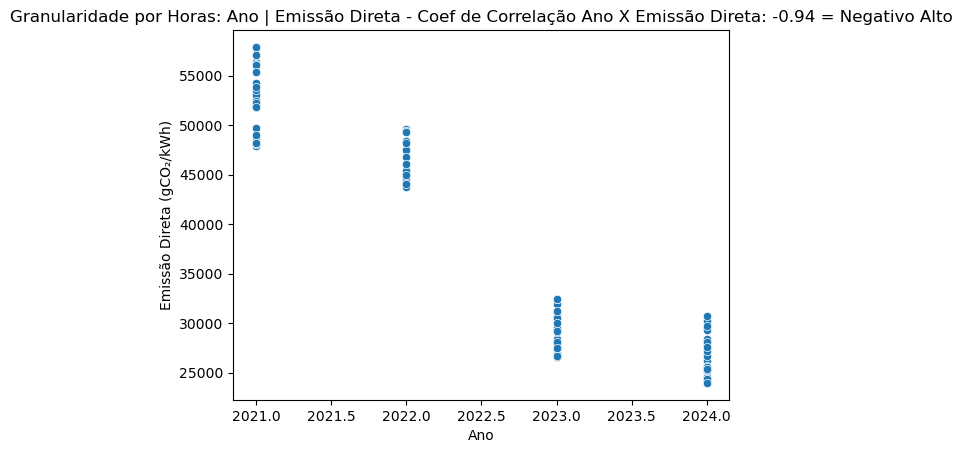

In [44]:
correlation = dk_hourly.year.corr(dk_hourly.total_direct_carbon_emission)

sns.scatterplot(data=dk_hourly, x='year', y='total_direct_carbon_emission')
plt.title(f'Granularidade por Horas: Ano | Emissão Direta - Coef de Correlação Ano X Emissão Direta: {correlation:.2f} = Negativo Alto')
plt.xlabel('Ano')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.show()

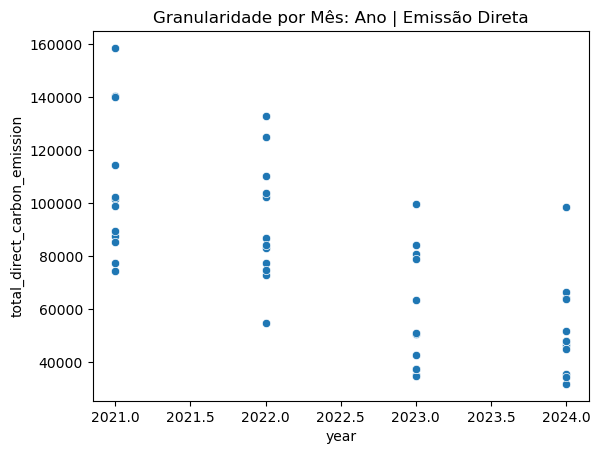

In [ ]:
sns.scatterplot(data=dk_general, x='year', y='total_direct_carbon_emission')
plt.title('Granularidade por Mês: Ano | Emissão Direta')
plt.show()

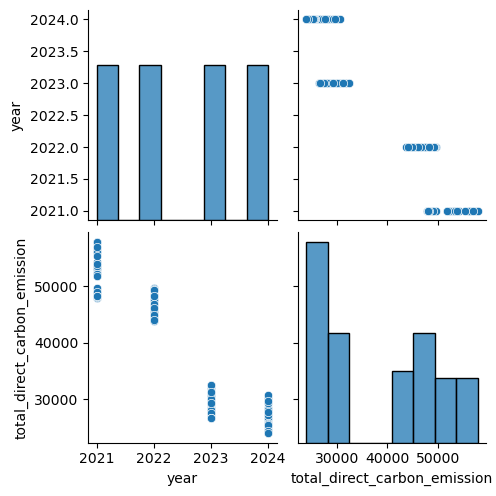

In [25]:
sns.pairplot(dk_hourly[['year', 'total_direct_carbon_emission']])

### 2021

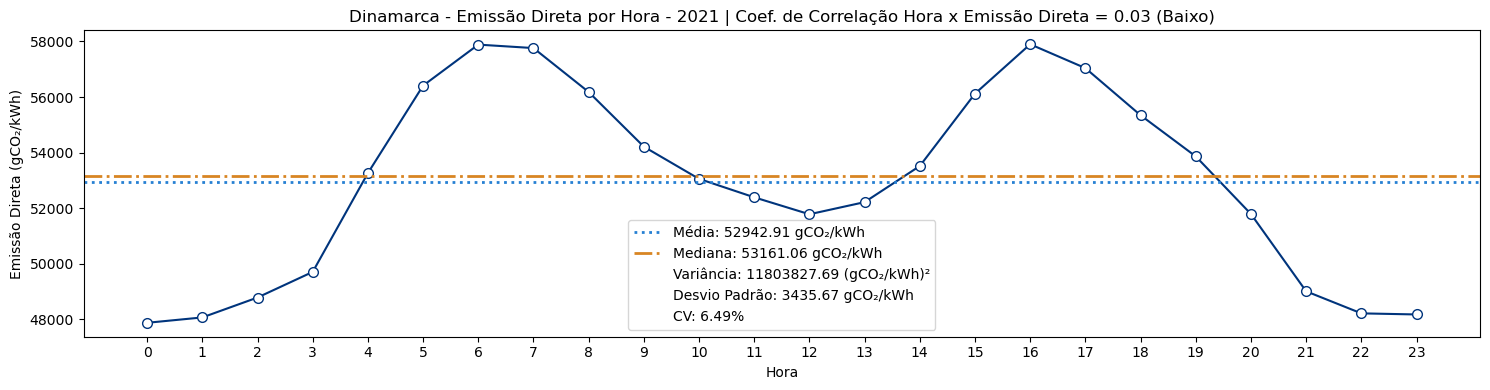

In [26]:
dk_hourly_2021 = dk_hourly[dk_hourly.year == 2021]

correlation = dk_hourly_2021.hour.corr(dk_hourly_2021.total_direct_carbon_emission)
mean = dk_hourly_2021.total_direct_carbon_emission.mean()
median = dk_hourly_2021.total_direct_carbon_emission.median()
std = dk_hourly_2021.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(dk_hourly_2021.hour, dk_hourly_2021.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Dinamarca - Emissão Direta por Hora - 2021 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

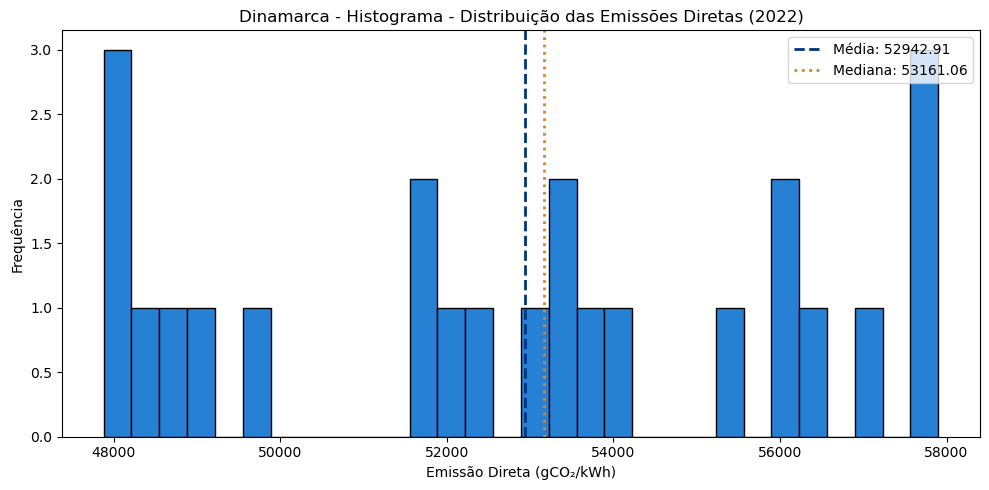

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(dk_hourly_2021.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(dk_hourly_2021.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {dk_hourly_2021.total_direct_carbon_emission.mean():.2f}')
plt.axvline(dk_hourly_2021.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {dk_hourly_2021.total_direct_carbon_emission.median():.2f}')
plt.title('Dinamarca - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

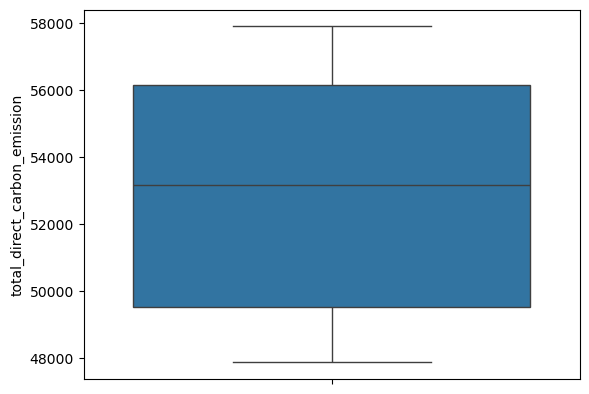

In [28]:
sns.boxplot(dk_hourly_2021.total_direct_carbon_emission)

In [29]:
dk_hourly.groupby('hour')['total_direct_carbon_emission'].max().reset_index().sort_values('total_direct_carbon_emission', ascending=False)

,hour,total_direct_carbon_emission
16,16,57900.66
6,6,57887.97
7,7,57763.43
17,17,57042.47
5,5,56412.27
8,8,56183.16
15,15,56123.30
18,18,55346.65
9,9,54215.60
19,19,53865.91


### 2022

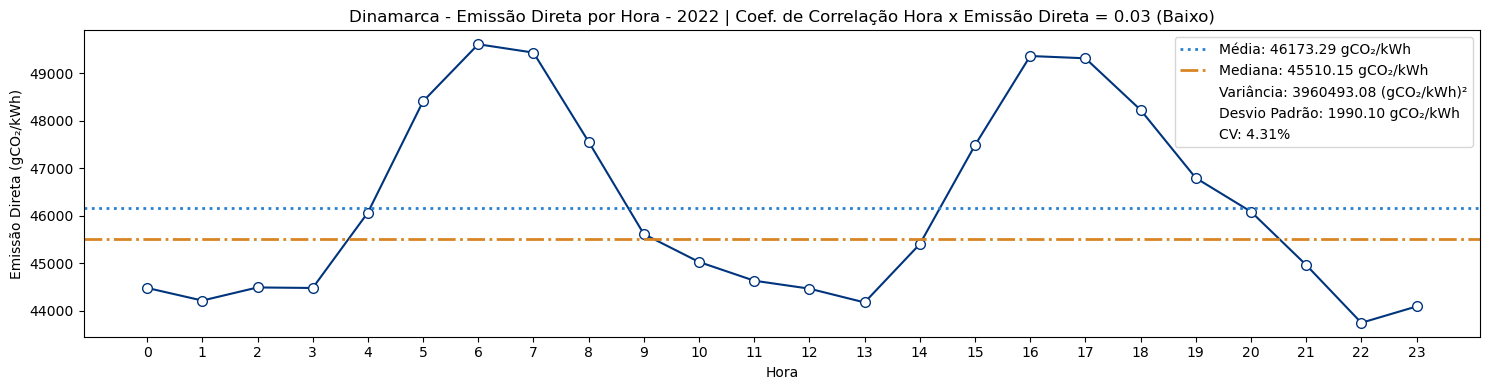

In [30]:
dk_hourly_2022 = dk_hourly[dk_hourly.year == 2022]

correlation = dk_hourly_2022.hour.corr(dk_hourly_2022.total_direct_carbon_emission)
mean = dk_hourly_2022.total_direct_carbon_emission.mean()
median = dk_hourly_2022.total_direct_carbon_emission.median()
std = dk_hourly_2022.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(dk_hourly_2022.hour, dk_hourly_2022.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Dinamarca - Emissão Direta por Hora - 2022 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

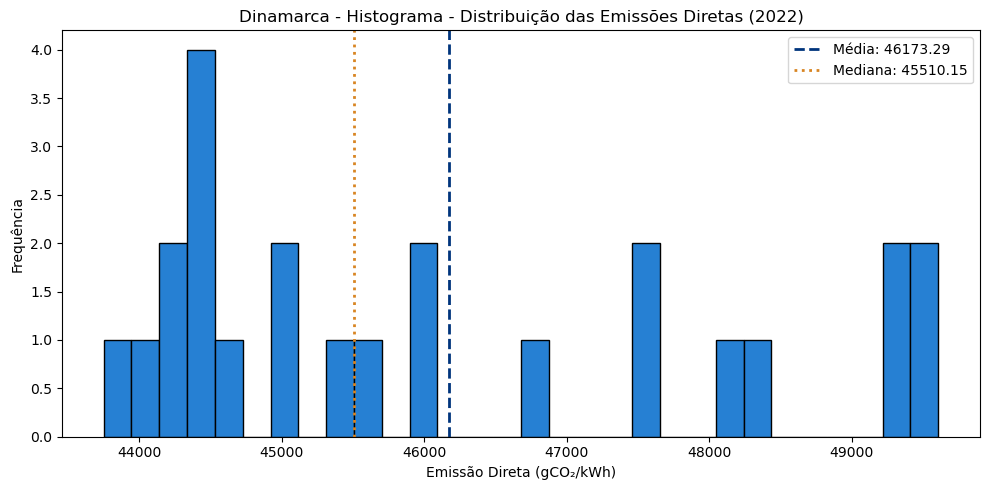

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(dk_hourly_2022.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(dk_hourly_2022.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {dk_hourly_2022.total_direct_carbon_emission.mean():.2f}')
plt.axvline(dk_hourly_2022.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {dk_hourly_2022.total_direct_carbon_emission.median():.2f}')
plt.title('Dinamarca - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

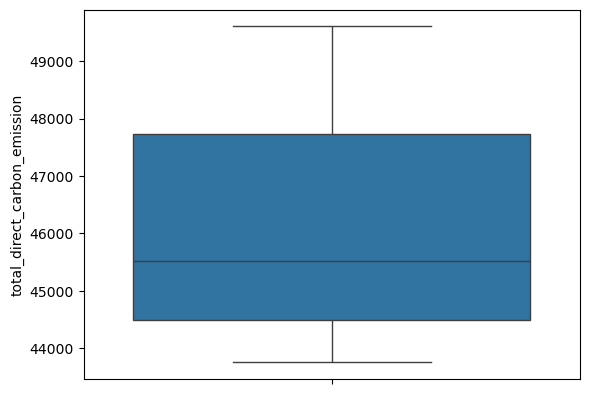

In [32]:
sns.boxplot(dk_hourly_2022.total_direct_carbon_emission)

### 2023

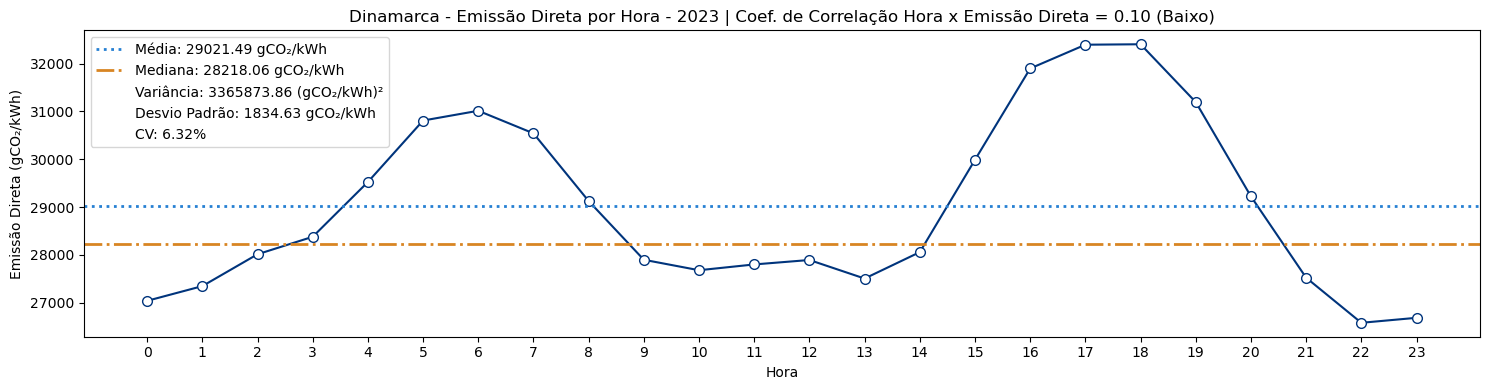

In [33]:
dk_hourly_2023 = dk_hourly[dk_hourly.year == 2023]

correlation = dk_hourly_2023.hour.corr(dk_hourly_2023.total_direct_carbon_emission)
mean = dk_hourly_2023.total_direct_carbon_emission.mean()
median = dk_hourly_2023.total_direct_carbon_emission.median()
std = dk_hourly_2023.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(dk_hourly_2023.hour, dk_hourly_2023.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Dinamarca - Emissão Direta por Hora - 2023 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

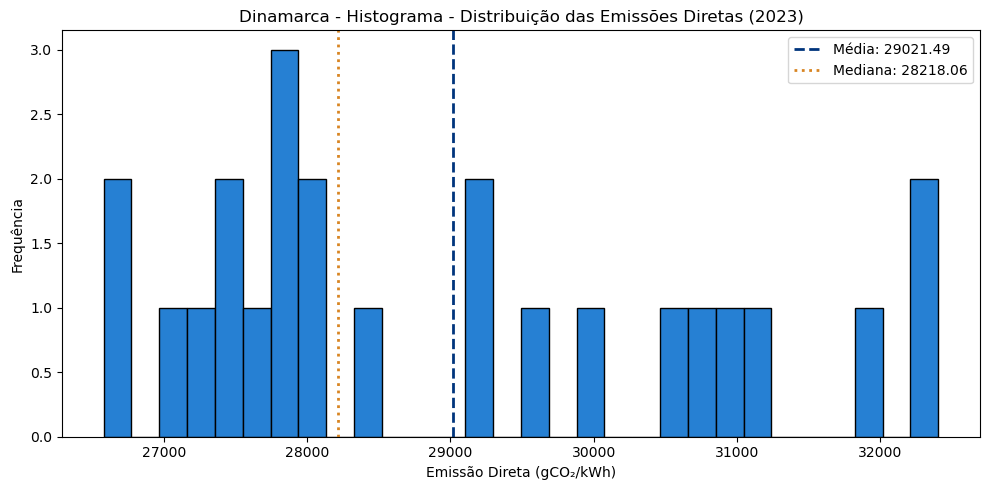

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(dk_hourly_2023.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(dk_hourly_2023.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {dk_hourly_2023.total_direct_carbon_emission.mean():.2f}')
plt.axvline(dk_hourly_2023.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {dk_hourly_2023.total_direct_carbon_emission.median():.2f}')
plt.title('Dinamarca - Histograma - Distribuição das Emissões Diretas (2023)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

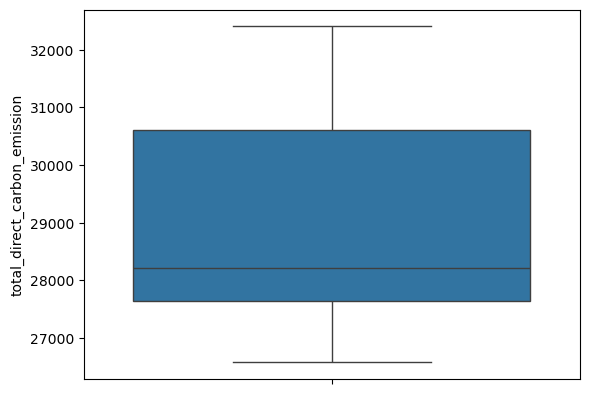

In [35]:
sns.boxplot(dk_hourly_2023.total_direct_carbon_emission)

### 2024

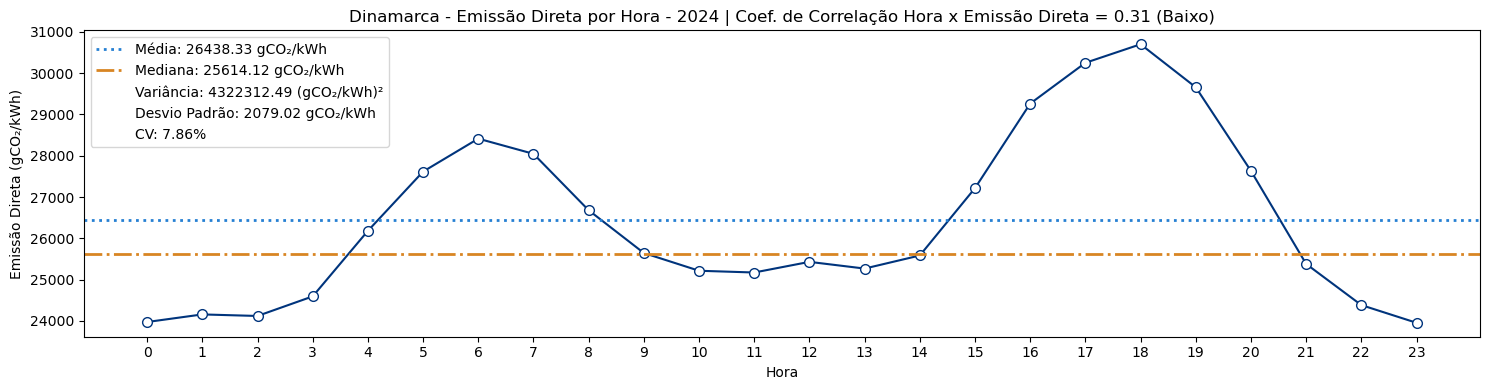

In [36]:
dk_hourly_2024 = dk_hourly[dk_hourly.year == 2024]

correlation = dk_hourly_2024.hour.corr(dk_hourly_2024.total_direct_carbon_emission)
mean = dk_hourly_2024.total_direct_carbon_emission.mean()
median = dk_hourly_2024.total_direct_carbon_emission.median()
std = dk_hourly_2024.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(dk_hourly_2024.hour, dk_hourly_2024.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Dinamarca - Emissão Direta por Hora - 2024 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

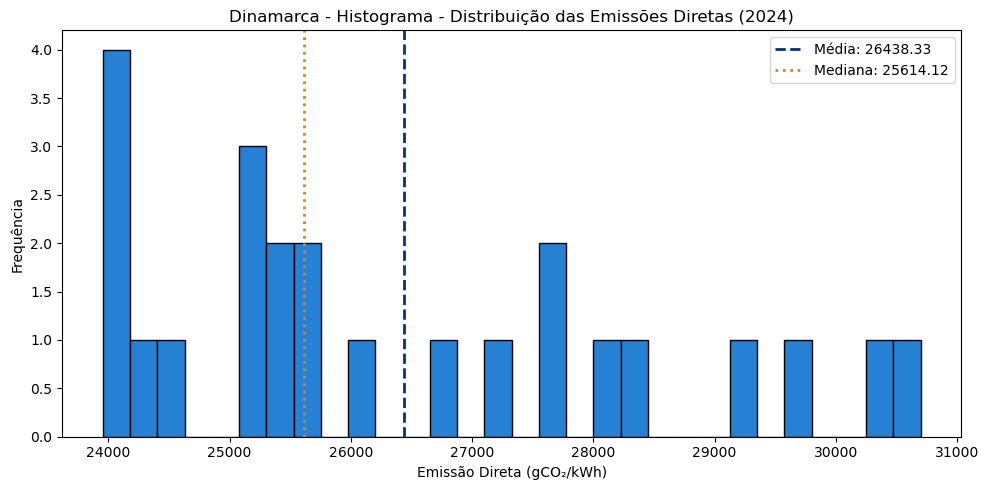

In [37]:
plt.figure(figsize=(10, 5))
plt.hist(dk_hourly_2024.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(dk_hourly_2024.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {dk_hourly_2024.total_direct_carbon_emission.mean():.2f}')
plt.axvline(dk_hourly_2024.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {dk_hourly_2024.total_direct_carbon_emission.median():.2f}')
plt.title('Dinamarca - Histograma - Distribuição das Emissões Diretas (2024)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

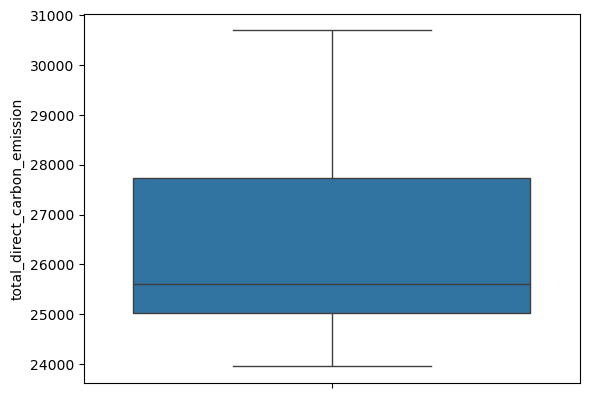

In [38]:
sns.boxplot(dk_hourly_2024.total_direct_carbon_emission)